# Estimation of Undiscovered Deposits in Quantitative Mineral Resource Assessments
## Deposit Density Method
Based ond Dennis P. Cox 

 Low-sulfide gold-quartz veins (LGV's) 
 
 Data from James D. Bliss
 All mines within 1.6 km were combined and only deposits containing more than 99 tonnes
are included. Gold grade is correlated with tonnage (r = -0.30) and with silver grade (r = 0.45, n
= 39).

![imagen.png](MiningData/LGVModel.png)

### Grade and tonnage model.
Ideally, the data should be the estimated premining tonnages and grades.

In [1]:
## Librerias

import pandas as pd
import numpy as np
from numpy import random
from math import log

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

#Distribucion Normal
from scipy.stats import norm, kstest
from scipy import stats

#Test de normalidad
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, pearsonr

#
from termcolor import colored, cprint

plt.style.use('seaborn')

ModuleNotFoundError: No module named 'termcolor'

## Measure Units Conversions

1 troy ounce equals 31.103481 grams per ton, which equals 34.2857 grams per tonne. As 1 gram equals 0.0321492 troy ounces, the conversion factor is calculated as: 0.0321492 / 34.2857 x 31.103481 = 0.0291652 (rounded 0.029).



Although mineral values are often expressed in tonne, sometimes they are expressed by ton as well. As 1 ton equals 907.18474 kilograms and 1 tonne equals 1,000 kilograms, just remember the difference between tonne and ton is approximately 10% (mnemonic: less letters, less outcome).

Converting to SI units, 1 oz/ton equals 31.10 g (1 oz troy) per 0.9072 tonne (1 short ton), which multiplies out as 34.28 g/t.


### How to Convert Grades
 

 Percent grade |	Grams per ton | ppm | 	ppb 
 --- | --- | --- | --- 
 1.00%	= |	10,000gpt	= |	10,000ppm	= |	10,000,000ppb 
0.1%	= |	1 ,000gpt	= |	1,000ppm	= |	1,000,000ppb
0.01%	= |	100gpt	= |	100ppm	= |	100,000ppb
0.001%	= |	10gpt	= |	10ppm	= |	10,000ppb
0.000,1%	= |	1gpt	= |	1ppm	= |	1,000ppb
0.000,01%	= |	0.1gpt	= |	0.1ppm	= |	100ppb
 
Abbreviation	Unit	Equivalents

oz = 31.103 g

(Troy) ounce (also 'ozt')

> A common ounce is known as an avoir dupois ounce, and is 28.34g. Troy ounces are only used for precious metals, gems and gunpowder, but are 10% larger,  1 Troy oz is 31.1034768 g, and is either referred to as 'oz' or 'ozt'. Since all gold ounces are troy ounces, if 'oz' is used with gold, it refers to the Troy ounce. To make things extra complex, a Troy pound is smaller than a common 'pound', because it only contains 12 troy ounces, not 16 oz, as the avoir dupois 'common' pound does. The troy pound is 373.24 g, while an avoirdupois pound is 453.59g.

In [ ]:
#Conversiones entre medidas

def troyOunces2gram(ounces):
    return onces / 31.103481

def gram2troyOunces(grams):
    return grams * 31.103481

def ouncesTonne2gramTonne(gradeOunces):
    return gradeOunces / 0.0291652

def gramTonne2ouncesTonne(gradeGrams):
    return gradeGrams * 0.0291652

def tonne2ton(tnn):
    return tnn /  907.18474

def ton2tonne(t):
    return tn *  907.18474

def percent2gramTonne(gradePercent):
    return gradePercent * 10000


def TaylorRuleofYacLife(t):
    '''
    Regla de Taylor para el cálculo de la vida del yacimiento
    t = Tonneage
    '''
    return 0.2 * ( t ** 0.25 )

In [ ]:
def freedman_diaconis(data, returnas="width"):
    """
    Use Freedman Diaconis rule to compute optimal histogram bin width. 
    ``returnas`` can be one of "width" or "bins", indicating whether
    the bin width or number of bins should be returned respectively. 


    Parameters
    ----------
    data: np.ndarray
        One-dimensional array.

    returnas: {"width", "bins"}
        If "width", return the estimated width for each histogram bin. 
        If "bins", return the number of bins suggested by rule.
    """
    data = np.asarray(data, dtype=np.float_)
    IQR  = stats.iqr(data, rng=(25, 75), scale="raw", nan_policy="omit")
    N    = data.size
    bw   = (2 * IQR) / np.power(N, 1/3)

    if returnas=="width":
        result = bw
    else:
        datmin, datmax = data.min(), data.max()
        datrng = datmax - datmin
        result = int((datrng / bw) + 1)
        
    return(result)

In [ ]:
#Clasificador por categorias mayor menor-igual
def classBySteps(x, stepLst):
    groupNdx  = 0
    groupName = ''
    for i in range(len(stepLst)-1):
        if x > stepLst[i] and x <= stepLst[i+1]:
            groupNdx = i
            groupName = str(stepLst[i]) + "-" + str(stepLst[i+1])
        elif i == 0:
            groupNdx = i
            groupName = str(stepLst[i]) + "-" + str(stepLst[i+1])
        
    
    return (groupNdx, groupName)

In [2]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    
    This function plots the confidence ellipse of the covariance of the given array-like variables x and y.
    The ellipse is plotted into the given axes-object ax.
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [3]:
def std_ellipse(x, y, ax, n_std=1, facecolor='none', **kwargs):
    """
    Create a plot of the standar desviation ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    
    
    """
    # two-dimensionl dataset.

    
    ellipse = Ellipse((np.mean(x), np.mean(y)), width=np.std(x) * 2 , height=np.std(y) * 2,
                      facecolor=facecolor, **kwargs)

    return ax.add_patch(ellipse)

# Modelado Numérico de Depósitos

In [4]:
# Ingresar Modelo de Depósito

depModelDF = pd.read_csv("../data/25b.csv")


In [5]:
depModelDF.head()

,yacName,Loc,tonn,Au,Ag,Cu,Pb,Zn
0,ANIMAS,USA,8500000.0,0.00034,0.0099,0.45,2.0,300.0
1,BONANZA,USA,508000.0,0.00010,0.0237,1.20,2.6,230.0
2,CASAPALCA,PERU,17000000.0,0.00010,0.0161,0.30,1.8,3500.0
3,CHAVIN,PERU,315000.0,0.00000,0.0125,0.80,8.0,12500.0
4,COCO MINA,NICA,10300000.0,0.00017,0.0026,0.00,0.0,3400.0


## Parametros Estadísticos

In [6]:
columName    = "tonn"
depModelTonn = depModelDF.loc[depModelDF[columName] > 0 ][columName] #Filtrar datos diferentes de cero
depModelPob  = depModelTonn.size
depModelMin  = depModelTonn.min()
depModelMax  = depModelTonn.max()
depModelMean = depModelTonn.mean()


print(f"Población: {depModelPob}")
#print(f"Min: {depModelMin:,.2f}T, Max: {depModelMax:,.2f}T")
print(f"Min: {depModelMin:,}%, Max: {depModelMax:,}%")
#print(f"Media sólo como referencia: {depModelMean:,.2f}T por si la distribución es log") #Este valor no tiene sentido porque la distribución es log
print(f"Media sólo como referencia: {depModelMean:,.10f} por si la distribución es log") #Este valor no tiene sentido porque la distribución es log


Población: 27
Min: 24,000.0%, Max: 107,000,000.0%
Media sólo como referencia: 8,191,518.5185185187 por si la distribución es log


### Exploración Valores máximos

In [7]:
depModelDF.loc[depModelDF['tonn'].idxmax()]


yacName    PACHUCA-R d MONTE
Loc                     MEXI
tonn             107000000.0
Au                   0.00022
Ag                    0.0461
Cu                      0.04
Pb                       0.2
Zn                     750.0
Name: 18, dtype: object

In [8]:
depModelDF.loc[depModelDF['Au'].idxmax()]

yacName    URUACHIC
Loc            MEXI
tonn        33000.0
Au           0.0032
Ag            0.136
Cu             0.15
Pb              1.6
Zn            200.0
Name: 25, dtype: object

### Distribución del Modelo de Depósito

Comprobamos gráficamente de que se trata de una distribución logaritmica

In [9]:
n_bins = freedman_diaconis(depModelTonn, returnas='bins')

fig, ax = plt.subplots(figsize=(8,4))

# Overlay a reversed cumulative histogram.
ax.hist(depModelTonn, 
        bins=n_bins, 
        density=True, 
        histtype='stepfilled', 
        cumulative=0
        #label='Low Suphidation Au Qrtz Veins'
       )

# tidy up the figure
ax.grid(True)
#ax.legend(loc='right')
ax.set_title('Histograma')
ax.set_xlabel('Tonelaje')
ax.set_ylabel('Proporción de Depósitos')

plt.show()

NameError: name 'freedman_diaconis' is not defined

## Estadísticos Según la Transformada Logarítmica

In [10]:
'''
Deposit density is number of deposits by 1.000 square km
'''
depModelTonnLog         = np.log10(depModelTonn)

depModelTonnPob         = depModelTonnLog.size
depModelTonnLogMin      = depModelTonnLog.min()
depModelTonnLogMax      = depModelTonnLog.max()
depModelTonnLogMean     = depModelTonnLog.mean()
depModelTonnLogMean2dec = 10 ** depModelTonnLogMean
depModelTonnLogStd      = depModelTonnLog.std()
depModelTonnLog10p      = depModelTonnLog.quantile(.10)
depModelTonnLog50p      = depModelTonnLog.quantile(.50)
depModelTonnLog90p      = depModelTonnLog.quantile(.90)

#Habria que hacer el test de normalidad para aplicar este criterio

print(f"Población: {depModelTonnPob}")
print(f"Min: {depModelTonnLogMin:.2f} log(T), Max: {depModelTonnLogMax:.2f} log(T)")
print(f"Media: {depModelTonnLogMean:.2f}log(T), {depModelTonnLogMean2dec:,.2f} T")
print(f"Desviación Estándar: {depModelTonnLogStd:.2f}")
print(f"Percentiles 10%: {depModelTonnLog10p:.2f} log(T) 50%: {depModelTonnLog50p:.2f} log(T) (mediana) 90%: {depModelTonnLog90p:.2f} log(T)")

Población: 27
Min: 4.38 log(T), Max: 8.03 log(T)
Media: 6.15log(T), 1,414,640.95 T
Desviación Estándar: 0.94
Percentiles 10%: 4.85 log(T) 50%: 6.14 log(T) (mediana) 90%: 7.19 log(T)


## Comprobación de Normalidad del Modelo Numérico de Depósito

/home/gabriel/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


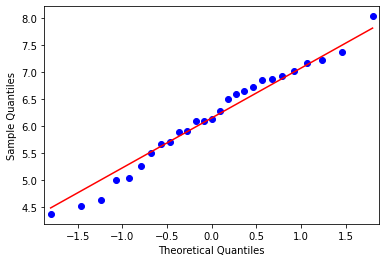

In [11]:
#Comprobación gráfica de normalidad
# q-q plot

qqplot(depModelTonnLog, line='s')

plt.show()

In [12]:
# normality test

'''
Statistic: A quantity calculated by the test that can be interpreted in the context of the test via comparing 
it to critical values from the distribution of the test statistic.
p-value: Used to interpret the test, in this case whether the sample was drawn from a Gaussian distribution.

'''

stat, p = shapiro(depModelTonnLog)

print('Estadístico=%.3f, p=%.3f' % (stat, p))

# interpret

alpha = 0.05

if p > alpha:
    cprint('Según Shapiro-Wilks la muestra parece tener distribución Gaussiana (NO se desecha la Hipótesis Nula)','red',  attrs=['bold'])
else:
    cprint('Según Shapiro-Wilk la muestra NO parece tener distribución Gaussiana (se desecha la Hipótesis Nula)','red',  attrs=['bold'])

Estadístico=0.975, p=0.748


NameError: name 'cprint' is not defined

If the p value is less than the chosen alpha level, then the null hypothesis is rejected and there is evidence that the data tested are not normally distributed. On the other hand, if the p value is greater than the chosen alpha level, then the null hypothesis that the data came from a normally distributed population can not be rejected (e.g., for an alpha level of .05, a data set with a p value of less than .05 rejects the null hypothesis that the data are from a normally distributed population).

Like most statistical significance tests, if the sample size is sufficiently large this test may detect even trivial departures from the null hypothesis (i.e., although there may be some statistically significant effect, it may be too small to be of any practical significance); thus, additional investigation of the effect size is typically advisable, e.g., a Q–Q plot in this case. (from Wikipedia)

p-values are very dependent on sample sizes. With a large sample, almost anything desviation can be significant.

In [13]:
#The KS test is only valid for continuous distributions.
#https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html

ksResult = kstest(depModelTonnLog, 'norm')
print(ksResult)

KstestResult(statistic=0.999994071784309, pvalue=1.479033130321458e-141)


In [14]:
n_bins = freedman_diaconis(depModelTonnLog, returnas='bins')

fig, ax = plt.subplots(figsize=(8,8))

# Overlay a reversed cumulative histogram.
ax.hist(depModelTonnLog, 
        bins=n_bins, 
        density=True, 
        histtype='stepfilled', 
        cumulative=0
        #label='Low Suphidation Au Qrtz Veins'
       )

# tidy up the figure
ax.grid(True)
#ax.legend(loc='right')
ax.set_title('Histograma')
ax.set_xlabel('Tonelaje (log10)')
ax.set_ylabel('Nro. de Depósitos')

plt.show()

NameError: name 'freedman_diaconis' is not defined

In [15]:
#Calculo del rango de tonelage entre log percentil 10 y 90
depModelTonnLog10p2Dec = 10 ** depModelTonnLog10p
depModelTonnLog90p2Dec = 10 ** depModelTonnLog90p

print(f"El 80% de los tonelages se encuentran entre {depModelTonnLog10p2Dec:,.0f} y  {depModelTonnLog90p2Dec:,.0f} T")
print(f'El valor medio será de {depModelTonnLogMean2dec:,.2f} T')

El 80% de los tonelages se encuentran entre 71,349 y  15,388,527 T
El valor medio será de 1,414,640.95 T


**Habria que hacer el análisis de Normalidad a las Leyes**

## Estadísticos para  Menas (Au, Ag)

In [16]:
LogAu     = np.log10(depModelDF.loc[depModelDF['Au'] > 0 ]['Au'])
LogTonnAu = np.log10(depModelDF.loc[depModelDF['Au'] > 0 ]['tonn'])

LogAg     = np.log10(depModelDF.loc[depModelDF['Ag'] > 0 ]['Ag'])
LogTonnAg = np.log10(depModelDF.loc[depModelDF['Ag'] > 0 ]['tonn'])


LogAuMin  = LogAu.min()
LogAuMax  = LogAu.max()
LogAuMean = np.mean(LogAu)
LogAuStd  = np.std(LogAu)
LogAu10p  = np.percentile(LogAu, 10)
LogAu50p  = np.percentile(LogAu, 50)
LogAu90p  = np.percentile(LogAu, 90)

#Habria que hacer el test de normalidad para aplicar este criterio

print(f"Población: {depModelTonnPob}")
print(f"Min: {LogAuMin:.5f}%, Max: {LogAuMax:.5f}%")
print(f"Media: {LogAuMean:.5f}")
print(f"Desviación Estándar: {LogAuStd:.5f}")
print(f"Percentiles 10%: {LogAu10p:.5f}% 50%: {LogAu50p:.5f}% (mediana) 90%: {LogAu90p:.5f}%")

#para pasar de % a gramos por tonelada hay que multiplicar por 10.000

Población: 27
Min: -4.69897%, Max: -2.49485%
Media: -3.67345
Desviación Estándar: 0.57447
Percentiles 10%: -4.52288% 50%: -3.65758% (mediana) 90%: -2.97999%


## Correlación entre Tonelaje y Ley
Habría que poner el cuadro en una escala correcta para comparación

### Correlación

In [17]:
covarianceTonnAu = np.cov(LogTonnAu,LogAu) #Calculo de la MATRIZ de covarianza

'''
 Coeficiente de Correlación de Pearson
 It is the normalization of the covariance between the two variables to give an interpretable score.
 Pearson's correlation coefficient = covariance(X, Y) / (stdv(X) * stdv(Y))
'''
corr, p  = pearsonr(LogTonnAu,LogAu)

print(f"El coficiente de correlación de Pearson es de: {corr:.2f}")
print(f"El valor calculado de p es de : {p:.4f}")

print()

if corr > 0:
    cprint("La relación tiene pendiente positiva",'red',  attrs=['bold'])
else:
    cprint("La relación tiene pendiente negativa",'red',  attrs=['bold'])
    
    
# Esto habría que definirlo en términos de clasificación fuzzy

if abs(corr) > 0.5 :
    cprint("El índice de correlación parece indicar que la misma es fuerte",'red',  attrs=['bold'])
elif abs(corr) <= 0.5 and abs(corr) > 0:
    cprint("El índice de correlación parece indicar que la misma es débil",'red',  attrs=['bold'])
elif corr == 0:
    cprint("El índice define que no hay correlación",'red',  attrs=['bold'])


El coficiente de correlación de Pearson es de: -0.37
El valor calculado de p es de : 0.0794



NameError: name 'cprint' is not defined

In [18]:
# Regression

slope, intercept, r, p, stderr = stats.linregress(LogTonnAu,LogAu)

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
print(line)

Regression line: y=-2.12+-0.25x, r=-0.37


y=-2.09+-0.18x, r=-0.33

Valor teórico del Ley/Grado para el tonelaje dado

10 <sup>-( 2,09 + 0,18 * log10(9.840.000))</sup>= 0,000447982 %

### Diagrama de Disperción

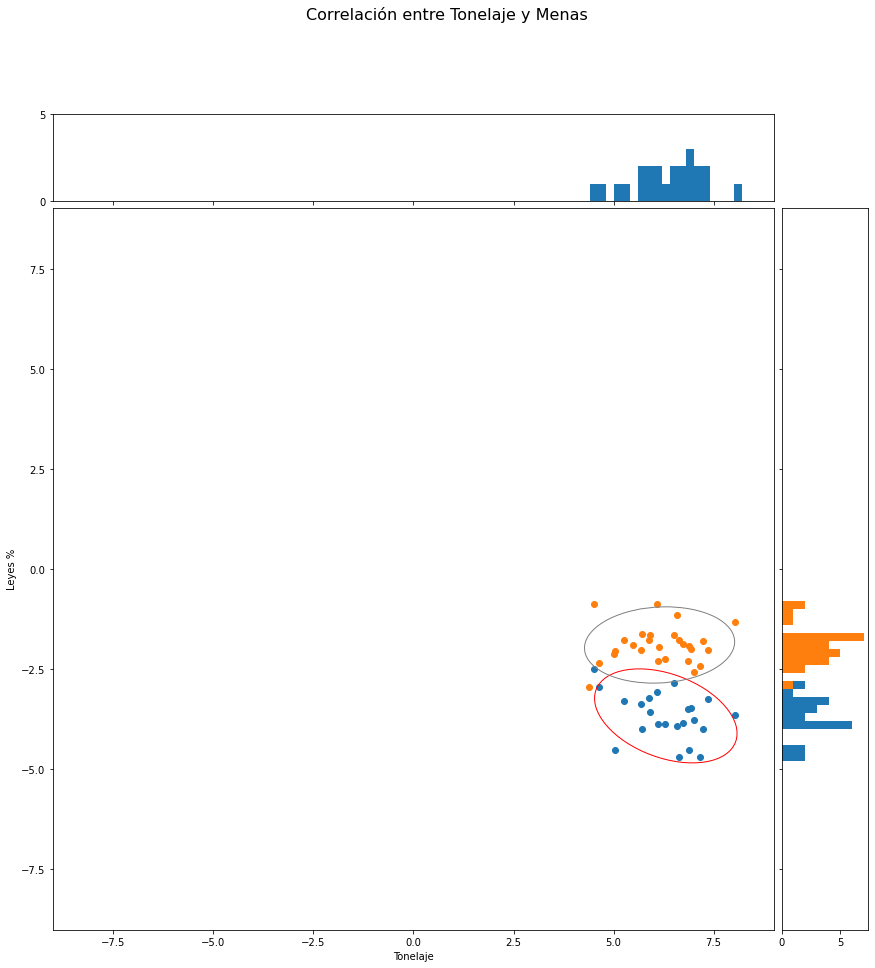

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axScatter = plt.subplots(figsize=(15, 15))

# the scatter plot:
axScatter.scatter(LogTonnAu, LogAu)
axScatter.scatter(LogTonnAg, LogAg)
axScatter.set_aspect(1.)
fig.suptitle('Correlación entre Tonelaje y Menas', fontsize=16)

axScatter.set_xlabel('Tonelaje')
axScatter.set_ylabel('Leyes %')

#Regression
#axScatter.plot(LSQVLog, intercept + slope * LSQVLog, label=line) #Hay diferencias entre la ellipse y la regresion

# create new axes on the right and on the top of the current axes
# The first argument of the new_vertical(new_horizontal) method is
# the height (width) of the axes to be created in inches.
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

# make some labels invisible
axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 0.2
xymax = max(np.max(np.abs(LogTonnAu)), np.max(np.abs(LogAu)))
lim = (int(xymax/binwidth) + 1)*binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(LogTonnAu, bins=bins)
axHisty.hist(LogAu, bins=bins, orientation='horizontal')
axHisty.hist(LogAg, bins=bins, orientation='horizontal')

confidence_ellipse(LogTonnAu, LogAu, axScatter, 2, edgecolor='red')
confidence_ellipse(LogTonnAg, LogAg, axScatter, 2, edgecolor='grey')

# the xaxis of axHistx and yaxis of axHisty are shared with axScatter,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

axHistx.set_yticks([0, 5])

axHisty.set_xticks([0, 5])


plt.show()

## Diagrama Tonelaje Ley

NameError: name 'LSQVLog' is not defined

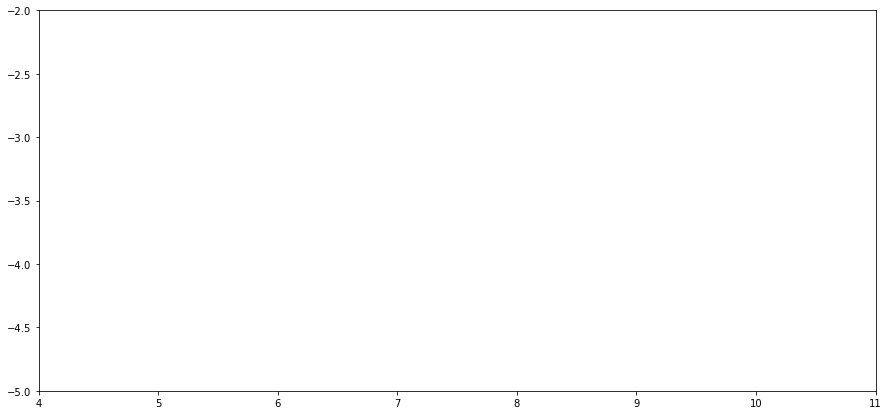

In [20]:
# Diagrama Tonelaje y Ley para Au Agrupados Tipo de Modelo de Yacimiento

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axScatter = plt.subplots(figsize=(15, 7))

# parametros del subplot
axScatter.set_xlim(4,11)
axScatter.set_ylim(-5, -2)

# the scatter plot:
axScatter.scatter(LSQVLog, LSQVLogAu)

#Lineas de igual ley x tonelaje
AuxTonneX = [4,8]
AuxTonneY = [ -2,-6]
axScatter.plot(AuxTonneX, AuxTonneY, label='1T Au', linewidth=2, color='gray',linestyle='dashed')

AuxTonneX = [4,9]
AuxTonneY = [ -1,-6]
axScatter.plot(AuxTonneX, AuxTonneY, label='10T Au', linewidth=2, color='gray',linestyle='dashed')

AuxTonneX = [4,10]
AuxTonneY = [ -0,-6]
axScatter.plot(AuxTonneX, AuxTonneY, label='100T Au', linewidth=2, color='gray',linestyle='dashed')

AuxTonneX = [4,11]
AuxTonneY = [ 1,-6]
axScatter.plot(AuxTonneX, AuxTonneY, label='1000T Au', linewidth=2, color='gray',linestyle='dashed')

AuxTonneX = [4,12]
AuxTonneY = [ 2,-6]
axScatter.plot(AuxTonneX, AuxTonneY, label='10000T Au', linewidth=2, color='gray',linestyle='dashed')
#axScatter.set_aspect(1.)
fig.suptitle('Diagrama Tonelaje y Ley para Au Agrupados por Tipo de Modelo de Yacimiento', fontsize=16)

axScatter.set_xlabel('Promedio de Tonelaje')
axScatter.set_ylabel('Promedio de Leyes %')

axScatter.text( 7,-4.9,'1T Au',rotation=-45, horizontalalignment='right')
axScatter.text(8,-4.9,'10T Au',rotation=-45, horizontalalignment='right')
axScatter.text(9,-4.9,'100T Au',rotation=-45, horizontalalignment='right')
axScatter.text(10,-4.9,'1000T Au',rotation=-45, horizontalalignment='right')


#axHisty.yaxis.set_tick_params(labelleft=False)


std_ellipse(LSQVLog, LSQVLogAu, axScatter, 1, edgecolor='red')




plt.show()

### Hay que ver bien como se definen los limites de y y en que unidades

Hay que dibujar la función de correlación y los parámetros
A la función de correlación se le dibuja el intervalo de confidencia que según singer puede ser 80%
Para el caso de que no haya correlación hay que definir un umbral para que no se dibuje

# Diagramas Bivariados. Comparación de Contenido y Calidad 
Hay que hacer el diagrama de scatter con elipse centro del promedio de la variable independiente y dependiente 
y radio 1sd. 

Los yacimientos gigantes se representan con un elefante.

La linea oblicua define el contenido total del yacimiento?. Debería ser tonelaje * ley

# EDA DEL YACIMIENTO

## Datos del Yacimiento a Estudiar

The current resource contains 9.84 million tonnes at 2.36 g/t AuEq for 746,000 oz in the Indicated category and a further

In [21]:
depName = 'Calcatreu v49-Nelson'
calcatreuIndicTonn = 7.83 * 10 ** 6
calcatreuAu        = 2.28
calcatreuAg        = 20.29

castroSurIndicTonn = 2.010 * 10 ** 6
castroSurAu        = 1.40
castroSurAg        = 14.77

calcatreuIndicLogTonn = np.log10(calcatreuIndicTonn)
calcatreuLogAu        = np.log10(calcatreuAu /10000) #g/t a %

castroSurIndicLogTonn = np.log10(castroSurIndicTonn)
castroSurLogAu        = np.log10(castroSurAu / 10000)
castroSurLogAg        = np.log10(castroSurAg)

print('Calcatreu v49')
print(calcatreuIndicLogTonn)
print(f"{calcatreuLogAu}%")

print()

print('Castro Sur')
print(castroSurIndicLogTonn)
print(castroSurLogAu)

Calcatreu v49
6.893761762057943
-3.642065152999546%

Castro Sur
6.303196057420489
-3.853871964321762


In [22]:
LSQVLogRandom = random.normal(loc=LSQVLogMean, scale=LSQVLogStd, size=(100000))


n_bins = 50
n_bins=freedman_diaconis(LSQVLog, returnas="bins")

fig, ax = plt.subplots(figsize=(16,8))

# Overlay a reversed cumulative histogram.
ax.hist(LSQVLog, 
        bins=n_bins, 
        density=True, 
        histtype='stepfilled', 
        cumulative=0,
        label='Función de Probabilidad de Masa (PMF)'
       )

xMax = LSQVLogMean + 3.5 * LSQVLogStd
xMin = LSQVLogMean - 3.5 * LSQVLogStd
x = np.linspace(xMin, xMax, 100)
ax.plot(x, norm.pdf(x, LSQVLogMean, LSQVLogStd), label='Distribución teórica (PDF)', color='black', linestyle='dashed')


#Yacimiento

#Valor del yacimiento en la funcion de probabilidad
zYac = norm.pdf(calcatreuIndicLogTonn, LSQVLogMean, LSQVLogStd) 
ax.plot([calcatreuIndicLogTonn], [zYac], marker='o', markersize=5, color='red')
ax.text(calcatreuIndicLogTonn, zYac +.015,'Calcatreu',rotation=90)
#/Yacimiento


ax.axvline(x=LSQVLog10p, color='r')
ax.text(LSQVLog10p,-0.04,'10%',rotation=90)

ax.axvline(x=LSQVLog50p, color='r')
ax.text(LSQVLog50p,-0.04,'50%',rotation=90)

ax.axvline(x=LSQVLog90p, color='r')
ax.text(LSQVLog90p,-0.04,'90%',rotation=90)

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Histograma Transformada Log 10')
ax.set_xlabel('Log Tonn ')
ax.set_ylabel('Proporción de Depósitos')
#ax.set_xscale('log')

plt.show()

NameError: name 'LSQVLogMean' is not defined

Percentiles calculados en base a la muestra

In [23]:
print(f'Probabilidad de ocurrencia: {zYac:.3f}')

NameError: name 'zYac' is not defined

NameError: name 'LSQVLog' is not defined

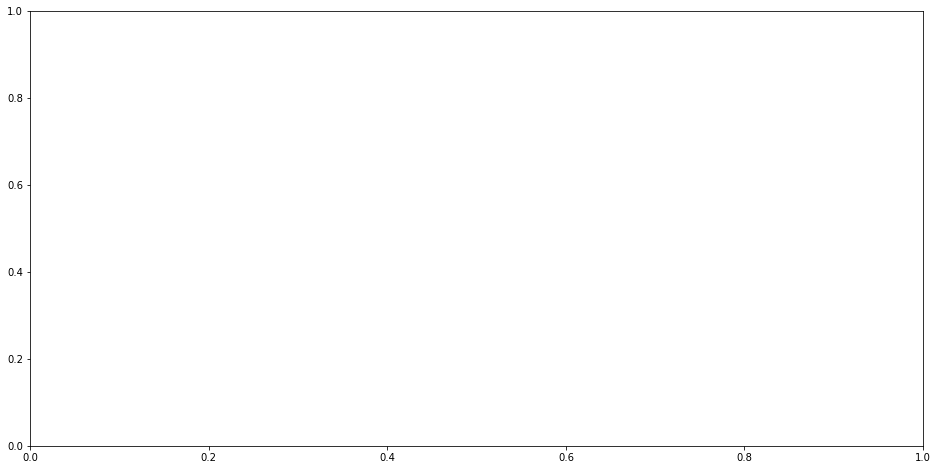

In [24]:
n_bins = 50


fig, ax = plt.subplots(figsize=(16,8))

# Overlay a reversed cumulative histogram.
n, bins, patches = ax.hist(LSQVLog, bins=n_bins, density=True, histtype='step', cumulative=-1,
        label='Tonelage')


x = np.linspace(xMin, xMax, 100)
ax.plot(x, norm.sf(x, LSQVLogMean, LSQVLogStd), label='Distribución teórica (PDF)', color='gray', linestyle='dashed')


ax.plot([calcatreuIndicLogTonn], [zYac], marker='o', markersize=5, color='red')
ax.text(calcatreuIndicLogTonn, zYac +.02,'Calcatreu',rotation=90)

LSQVLog.sort_values(inplace=True)
n = LSQVLog.size
y = [ 1 - (np.arange(1, n+1) / n)]


ax.plot([LSQVLog], y, marker='o', markersize=7, color='blue')
    

ax.axvline(x=LSQVLog10p, color='r')
ax.text(LSQVLog10p,1-0.04,'90%',rotation=90)

ax.axvline(x=LSQVLog50p, color='r')
ax.text(LSQVLog50p,1-0.04,'50%',rotation=90)

ax.axvline(x=LSQVLog90p, color='r')
ax.text(LSQVLog90p,1-0.04,'10%',rotation=90)


# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Inverse Survival Function  (ISF)')
ax.set_xlabel('Tonnelaje (escala log 10))')
ax.set_ylabel('ISF(x) Proporción de Depósitos Acumulada Inversa')

#renombrar xticks
xTicksLst    = [i for i in range(round(xMin), round(xMax) + 1)]
xTicksLabels = ['{:,.0f}'.format(10 ** x) for x in  xTicksLst]
ax.set_xticks(xTicksLst)  # Get the current locations and labels.
ax.set_xticklabels(xTicksLabels)


plt.show()

Percentiles calculados en base a la muestra

La inversa de la distribucion acumulada o Función de Supervivencia Inversa (ISF) nos indica  la chance de encontrar yacimientos mayores a un valor dado

## Leyes

In [33]:
zGrade = norm.pdf(calcatreuLogAu, LSQVLogAuMean, LSQVLogAuStd)
print(f'Z Grade {zGrade:.2f}; Log Au: {calcatreuLogAu:.2f}')


Z Grade nan; Log Au: -3.64


ValueError: supplied range of [-inf, -2.494850021680094] is not finite

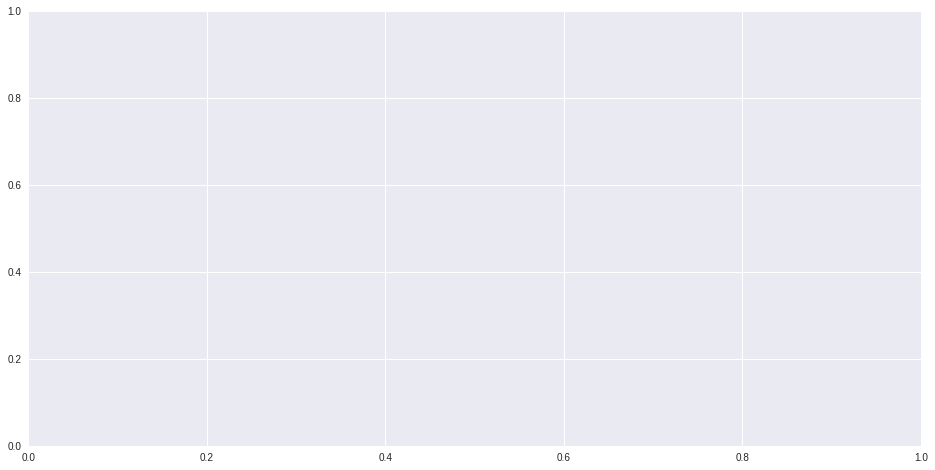

In [34]:
n_bins = 50


fig, ax = plt.subplots(figsize=(16,8))

# Overlay a reversed cumulative histogram.
n, bins, patches = ax.hist(LSQVLogAu, bins=n_bins, density=True, histtype='step', cumulative=-1,
        label='Low Suphidation Au Qrtz Veins')

xMax = LSQVLogAuMean + 3.5 * LSQVLogAuStd
xMin = LSQVLogAuMean - 3.5 * LSQVLogAuStd

x = np.linspace(xMin, xMax, 100)


ax.plot(x, norm.sf(x, LSQVLogAuMean, LSQVLogAuStd), 
        label='Distribución teórica', color='gray', linestyle='dashed')

#zYac = norm.pdf(calcatreuIndicLogTonn, LSQVLogMean, LSQVLogStd) 

#zGrade = norm.pdf(calcatreuLogAu, LSQVLogAuMean, LSQVLogAuStd)

#ax.plot([calcatreuLogAu], [zGrade], marker='o', markersize=5, color='red')
#ax.text(calcatreuLogAu, zGrade +.02,'Calcatreu',rotation=90)

ax.axvline(x=LSQVLogAu10p, color='r')
ax.text(LSQVLogAu10p,-0.04,'90%',rotation=90)

ax.axvline(x=LSQVLogAu50p, color='r')
ax.text(LSQVLogAu50p,-0.04,'50%',rotation=90)

ax.axvline(x=LSQVLogAu90p, color='r')
ax.text(LSQVLogAu90p,-0.04,'10%',rotation=90)


# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Inverse Survival Function  (ISF)')
ax.set_xlabel('log(Au Grade) LS Au Q Veins')
ax.set_ylabel('ISF(x)')


plt.show()